In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fft import rfft, rfftfreq
import random

## CS6650 Homework 1 (Holi 2023 Semester)
#### Smartphone based Photoplethysmography (PPG)
The task is to develop a PPG system using a smartphone device to capture blood flow related imagery data and post-process such data to estimate the pulse or heart beat rate of the subject. You need to implement various features pertaining to the above task in this notebook. Create a directory, <b><your_roll>_CS6650H23</b>. Place this notebook in that directory.

#### A. Warmup - Data Collection [10 points]
Use your smartphone’s camera to capture the blood-flow video. Turn on the flash while recording and turn it off once done. Capture the video using the maximum frame rate that is available in your phone (e.g.60 fps or 30 fps). The same holds for image resolution. The captured videos are saved on the device’s SD card. Collect 3 such videos (each exactly 10 seconds long, if longer just limit to N frames while processing, where N = 10*frames_per_second) under the following conditions. Make sure that all video capture configurations are kept the same across the cases (resolution, fps).
* resting on bed (1.mp4)
* after a moderate walk (2.mp4), and
* after a vigorous exercise (3.mp4).

Copy these videos locally to your project folder in a subdirectory "ppgvideos" - name them (1/2/3).mp4. Don’t move your finger/hand randomly or press too hard against the camera or flash while recording, little randomness is okay. Write a script to read the three videos and store the frames (2D vector of (R G B) values).

# Answer to A
Fetching and understanding the dataset

In [1]:
## your snippet to read the three videos, display the number of frames and resolution in each video
import cv2

videoPaths = ["ppgvideos/1.mp4", "ppgvideos/2.mp4", "ppgvideos/3.mp4"]
# This is a map from the video ID to its list of frames.
videoFrames = {"1":[], "2":[], "3":[]}

for index, videoPath in enumerate(videoPaths):
    cap = cv2.VideoCapture(videoPath)

    #some sample constants in openCV, check out for more
    fps = cap.get(cv2.CAP_PROP_FPS)
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    f_w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    f_h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            videoFrames[str(index+1)].append(frame)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

    print(videoPath+", Frame Count: "+str(cnt)+", FPS: "+str(fps))

ModuleNotFoundError: No module named 'cv2'

In [44]:
# We print some important features of our dataset for the first sequence to help us gain an understanding
# of the dataset.
print("Type of variable videoFrames : {}".format(type(videoFrames)))
print("Type of videoFrames value (a sequence of frames) : {}".format(type(videoFrames["1"])))
print("Type of each frame : {}".format(type(videoFrames["1"][0])))
print("Type of each colour pixel : {}".format(type(videoFrames["1"][0][0, 0, 0])))
print("Len of sequence (number of frames) : {}".format(len(videoFrames["1"])))
print("Shape of frame : {}".format(videoFrames["1"][0].shape))
print("For a random pixel - Min value : {}  Max value : {}"
      .format(np.min(videoFrames["1"][0]), np.max(videoFrames["1"][0])))

Type of variable videoFrames : <class 'dict'>
Type of videoFrames value (a sequence of frames) : <class 'list'>
Type of each frame : <class 'numpy.ndarray'>
Type of each colour pixel : <class 'numpy.uint8'>
Len of sequence (number of frames) : 300
Shape of frame : (1920, 1080, 3)
For a random pixel - Min value : 0  Max value : 84


In [4]:
# Defining some global constants
sample_rate = 30 # The number of samples per second
duration = 10 # The duration for which samples were recorded
number_of_samples = sample_rate * duration # The total number of samples recorded

In [5]:
# Trimming sequences to contain only "number_of_samples" = 30x10 = 300
for key, videoFrame in videoFrames.items():
    videoFrames[key] = videoFrame[0:number_of_samples]

# Printing the number of frames again to check if the trimming worked.
for key, videoFrame in videoFrames.items():
    print("Video {} - Number of frames : {}  Shape of frame : {}".format(key, len(videoFrame), videoFrame[0].shape))

Video 1 - Number of frames : 300  Shape of frame : (1920, 1080, 3)
Video 2 - Number of frames : 300  Shape of frame : (1920, 1080, 3)
Video 3 - Number of frames : 300  Shape of frame : (1920, 1080, 3)


## Understanding how the frames are stored

1. Each video is stored as a list of frames with the length of list = number of frames.
In the example above this is 365, 321 and 347.
2. Each frame is a numpy ndarray with shape as 1920, 1080, 3 (For 3 color channels B, G, R)
Note : opencv's auto loading format is B.G.R and not R, G, B
3. Each B, G, R pixel value is of type np.uint8 implying they can stores values between 0-255

We can also see that the number of frames captured was 364, 321 and 347. Since the camera captured at a frame rate of 30fps and we need only a 10s sequence, we will take only the first 300 into account during any further processing.

# End of answer A

#### B. Sensing Metric [5 points]
Design your sensing metric. Note that each frame is a 2D vector of size [AxB], containing A.B pixels, where a pixel at location [i,j] is denoted by the 3-tuple [B, G, R] where B, G, and R are bytes (8 bits, range 0 - 255) representing intensity of each color - Blue, Green and Red. The frame intensity metric is an aggregate statistical measure on the pixel values. (you can even consider R, G and B streams separately or consider greyscale frames). Best to have a normalized value between zero and one. [5 points]

# Answer to B - Choosing a sensing metric
Since we do not know which aggregate metric is ideal - we can iterate over the four main aggregate metrics and see which works best for us.
The four metrics we are choosing are min, max, median and mean.
We are not choosing mode as it is too computationally expensive - you first need to bucket and then count values in each bucket and then find the value with maximum count.

##### Note : We are looking at only one video - the first one - below as having multiple plots for each video will make the notebook messy. But I have personally checked if the sensing metric works for all three of the videos.

Also, I am not normalizing any values to 0 and 1 for now as uint8 will work well for the below analysis and integer arithmetic is faster than float arithmetic.

In [6]:
# Since we are experimenting around and will need to graph the chosen list of aggregate metrics
# mutiple times, we write the following function for cleaner code.

def plot_four(x, y1, y2, y3, y4, y1_title, y2_title, y3_title, y4_title):
    """
    This function has the capability to plot four graphs with the same 'x' dimension.
    For our purpose, the four plots will be of min, max, mean and median.
    """
    # Creating subplots to plot multiple plots in one image. We are creating a 2x2 grid for each of the four statistical measures
    figure, axis = plt.subplots(2, 2)
    axis[0, 0].plot(x, y1)
    axis[0, 0].set_title(y1_title)
    axis[0, 1].plot(x, y2)
    axis[0, 1].set_title(y2_title)
    axis[1, 0].plot(x, y3)
    axis[1, 0].set_title(y3_title)
    axis[1, 1].plot(x, y4)
    axis[1, 1].set_title(y4_title)
    plt.show()

In [7]:
# Defining x as the length of the number of frames. Will be useful in plotting
x = list(range(len(videoFrames["1"])))

In [8]:
# We can first plot the aggregate metrics for the entire frame as a whole. 
# This considers the ndarray of 1920x1080x3 as a single array (akin to flattening the array)
list_min = []
list_max = []
list_median = []
list_mean = []
# Iterating through each frame of first video and adding the statistical measures to a list so as to plot it later on
for frame in videoFrames["1"]:
    list_max.append(np.max(frame))
    list_min.append(np.min(frame))
    list_mean.append(np.mean(frame))
    list_median.append(np.median(frame))

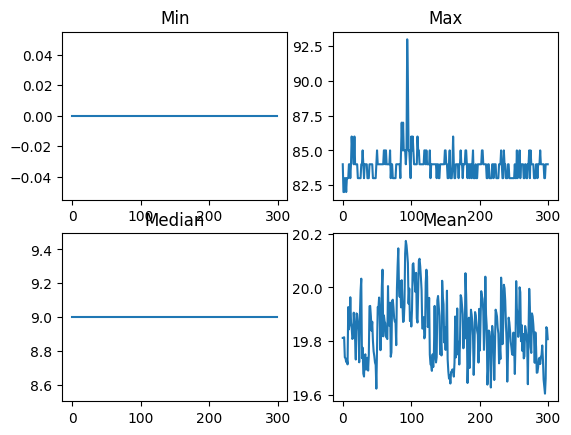

In [9]:
# The min, max, median and mean when taken across the entire frame for all B, G, R components.
plot_four(x, list_min, list_max, list_median, list_mean, "Min", "Max", "Median", "Mean")

In [10]:
# We can now plot the aggregate metrics for each B, G, R dimension to see if 
# any one of the arrays captures the same info as before.
# If they do, we can just use one channel, which will reduce the amount of data we will have
# to process - by a factor of 3. 

# In the below dict, 
# 0 refers to channel blue
# 1 refers to channel green
# 2 refers to channel red

list_min = {0:[], 1:[], 2:[]}
list_max = {0:[], 1:[], 2:[]}
list_median = {0:[], 1:[], 2:[]}
list_mean = {0:[], 1:[], 2:[]}
# Iterating through each frame of first video
for frame in videoFrames["1"]:
    # Iterating through each B, G, R, dimension (is the last dimension of the 3D array)
    for i in range(3):
        list_max[i].append(np.max(frame[:, :, i]))
        list_min[i].append(np.min(frame[:, :, i]))
        list_mean[i].append(np.mean(frame[:, :, i]))
        list_median[i].append(np.median(frame[:, :, i]))

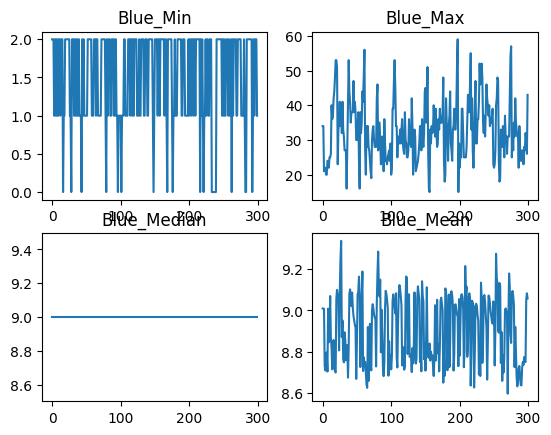

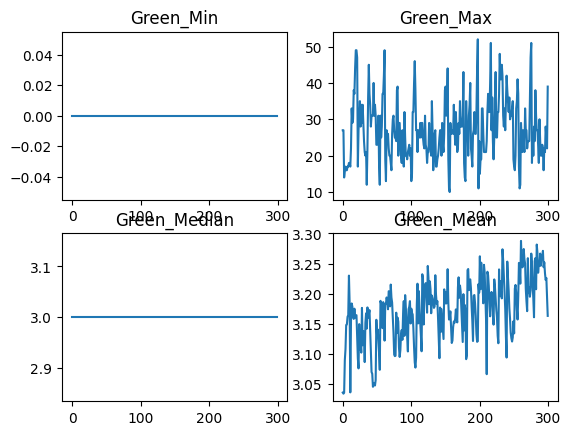

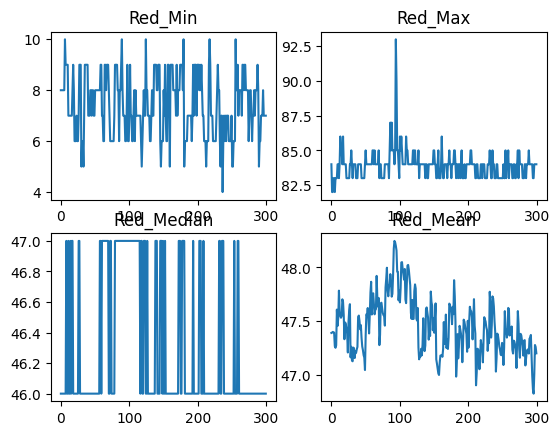

In [11]:
# Plotting Blue, Green and Red dimesion metrics
plot_four(x, list_min[0], list_max[0], list_median[0], list_mean[0], "Blue_Min", "Blue_Max", "Blue_Median", "Blue_Mean")
plot_four(x, list_min[1], list_max[1], list_median[1], list_mean[1], "Green_Min", "Green_Max", "Green_Median", "Green_Mean")
plot_four(x, list_min[2], list_max[2], list_median[2], list_mean[2], "Red_Min", "Red_Max", "Red_Median", "Red_Mean")

In [12]:
# We can now plot the aggregate metrics for the greyscale array to see if this captures 
# the same info as before.
# If they do, using greyscale is also a good alternative as this too will reduce 
# the amount of data we will have to process - by a factor of 3.

list_min = []
list_max = []
list_median = []
list_mean = []
# Iterating through each frame
for frame in videoFrames["1"]:
    # Converting to greyscale
    grey_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    list_max.append(np.max(grey_frame))
    list_min.append(np.min(grey_frame))
    list_mean.append(np.mean(grey_frame))
    list_median.append(np.median(grey_frame))

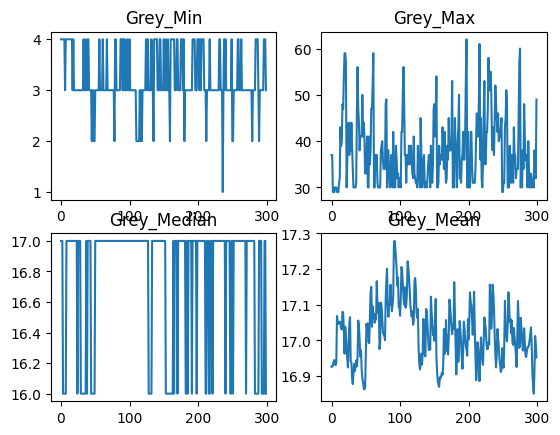

In [13]:
# Plotting min, max, mean and median for the greyscale image
plot_four(x, list_min, list_max, list_median, list_mean, "Grey_Min", "Grey_Max", "Grey_Median", "Grey_Mean")

## Our decision
As we can see above, in all three cases,
1. Considering the image as a whole
2. Considering only the B, G, or R components
3. Considering only the greyscale
<br>
, the information present is approximately the same. 


In that regard, I will opt to go for the greyscale image to apply our sensing metric because
1. When compared to case a, this requires less memory and processing - reduces memory and compute requirement by a factor of 3.
2. When compared to individual B, G, R values - greyscale contains more stable information as it is a mixture of all B, G, R values. 
Why is this more stable information?
Please note that we are looking at only one example, and in this example B, G, R seem to capture equal amounts of information. Imagine we go with the R component for our predictions, and for some reason, some human somewhere has a green finger (maybe due to a disease) for which processing in the Green dimension could have been better, we would have NOT been able to effectively predict due to a lack of any green dimension information.
As greyscale is a weighted average (reference - https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html) of all B, G, R components, the information will be less biased and thus more stable.


We can also note that min and median measures are not consistent across the cases, they seem to be quite random.
Whereas the info of max and mean appear more consistent. 
I will thus focus only on the max and mean measures as consistent and trustable sensing measures.

So now we have to choose, is max better or mean better?
For this, we have to analyze the distributions individually to see which can capture our hearbeat better.
Let's go ahead.


## The fight - max vs mean
To resolve the fight and understand which metric to choose, we can plot a FFT of both the metrics and check which one can capture heartbeat frequency better.

Note two things
1. Since we have finalized on greyscale, I will be using this to choose between max and mean.
2. The average heart beats between 60-100 seconds a minute (reference - https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979) while resting. This implies the heart beats about 1-1.67 times a second.

To check if max or mean captures heart beat information, let us plot an FFT of the time domains.

In [14]:
def plot_fft(time_input, sample_rate = 30, number_of_samples=300, time_title=""):
    """
    A function which can calculate the FFT of a time domain signal and plot it.
    """

    # This is a step to remove DC components (mean)
    t = np.array(time_input - np.mean(time_input))
    # Computes the fft
    yf = rfft(t)
    xf = rfftfreq(number_of_samples, 1 / sample_rate)
    # Plots the fft
    plt.plot(xf, np.abs(yf))
    plt.title(time_title)
    plt.show()
    return yf, xf

def get_frequency(yf, xf):
    """
    This function returns the frequency with maximum amplitude when given the frequency data.
    """
    # Computing the index of the maximum frequency 
    # and then doing a linear interpolation to get the actual frequency value
    return ((np.argmax(np.abs(yf))+1)/len(yf)) * np.max(xf)

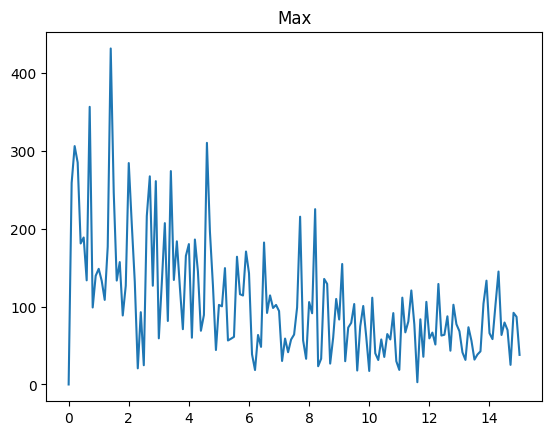

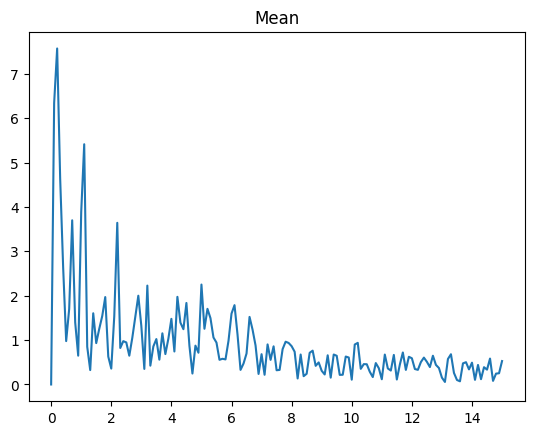

In [15]:
# Plotting the FFTs of max and mean of the greyscaled image
yf, xf = plot_fft(list_max, sample_rate, number_of_samples, "Max")
max_f = get_frequency(yf, xf)
yf, xf = plot_fft(list_mean, sample_rate, number_of_samples, "Mean")
mean_f = get_frequency(yf, xf)

In [16]:
# Fetching the frequencies with maximum value
print("Expected frequency fo heartbeat : 1 - 1.67 Hz")
print("Frequency of heatbeat from max : {} Hz".format(max_f))
print("Frequency of heatbeat from mean : {} Hz".format(mean_f))

Expected frequency fo heartbeat : 1 - 1.67 Hz
Frequency of heatbeat from max : 1.4900662251655628 Hz
Frequency of heatbeat from mean : 0.2980132450331126 Hz


## The winner
Looking at the above plots, we can see that 
1. both mean and max are able to capture heartbeat well.
2. max is able to distinguish the hearbeat better than mean due to more noise (visual analysis). 

But we can still choose to go with mean. This is because post 1Hz(range of human bpm), mean and max are performing equally well.
**In that range, median will also return the frequency of heart beat as 1.49Hz.**
And between median and max, max is more computationally expensive (requires dealing with memory which requires more compute cycles than an integer addition)

Our final chosen sensing metric is thus - The mean of the greyscaled image.

# End of Answer B

#### C. Temporal Variation of Intensity Value [10 points]
Plot your frame intensity metric vs. time for a random 5-second chunk of the three videos. The X-axis should be common for all three subplots (stacked vertically) with separate Y-axes based on your intensity metric. Appreciate the fact that vigorous exercise leads to rapid intensity variations compared to while resting. What is the BPM value for the three cases (manually counting is okay)?

# Answer to C

In [17]:
# To create a random five second chunk, we create a random integer point between 
# 0-4seconds and take the next 5 seconds post that as the random sequence
r = random.randint(0, 4)
print("Random time point is : {}".format(r))
videoFrames_5s = {"1":[], "2":[], "3":[]}
# Iterating through each video
for key, videoFrame in videoFrames.items():
    # Getting a 5second subset of the data
    videoFrame_subset = videoFrame[r : r+sample_rate*5]
    videoFrames_5s[key] = videoFrame_subset

Random time point is : 0


In [18]:
# Checking if the number of samples for each random sample is correct
# To be correct, the number of frames should be 30 * 5 = 150
for key, video in videoFrames_5s.items():
    print("Number of frames {} is {}".format(key, len(video)))

Number of frames 1 is 150
Number of frames 2 is 150
Number of frames 3 is 150


In [19]:
# Getting the intensity values for each frame according to our requirement
dict_frame_intensity = {"1" : [], "2" : [], "3" : []}
# For each video
for key, random_video in videoFrames_5s.items():
    # For each frame
    for frame in random_video:
        # Converting to greyscale
        grey_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Getting the mean
        dict_frame_intensity[key].append(np.mean(grey_frame))

In [21]:
# Plotting function for plotting three vertical plots - on our case to plot the intensity metric of the three videos

def plot_three_vertical(x, y1, y2, y3, y1_title, y2_title, y3_title):
# def plot_three_vertical(x, y1, y2, y1_title, y2_title):
    """
    This function has the capability to plot three graphs with the same 'x' dimension.
    For our purpose, the three plots will be of the three different sequences.
    """
    # Creating three subplots
    figure, axis = plt.subplots(3, 1)
    axis[0].plot(x, y1)
    axis[0].set_title(y1_title)
    axis[1].plot(x, y2)
    axis[1].set_title(y2_title)
    axis[2].plot(x, y3)
    axis[2].set_title(y3_title)
    plt.show()

In [20]:
# Defining this to make plotting easier
frame_intensity_x = list(range(150))

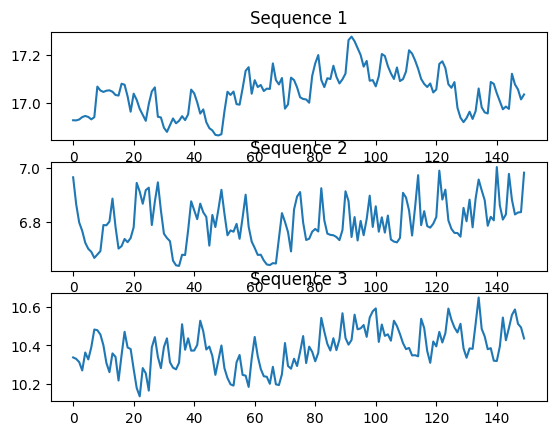

In [22]:
# Plotting the chosen frame intensity metric for all three videos
# Sequence is akin to video
plot_three_vertical(frame_intensity_x, dict_frame_intensity["1"], dict_frame_intensity["2"], dict_frame_intensity["3"]
                    , "Sequence 1", "Sequence 2", "Sequence 3")

### We can immediately see from the above graph that the heartbeat frequency is a lot higher for the third sequence - the sequence which was recorded after a fast run.
### Let us go on to plot the FFTs to find the heartbeat frequency as that is better than manual counting. 
Infact, I do not even know if a human can manually count the heartbeat frequency from this graph. 

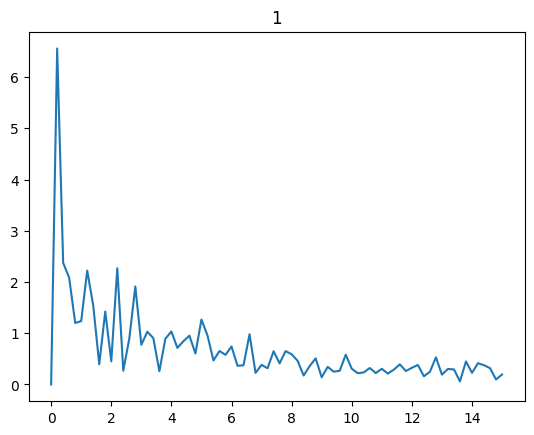

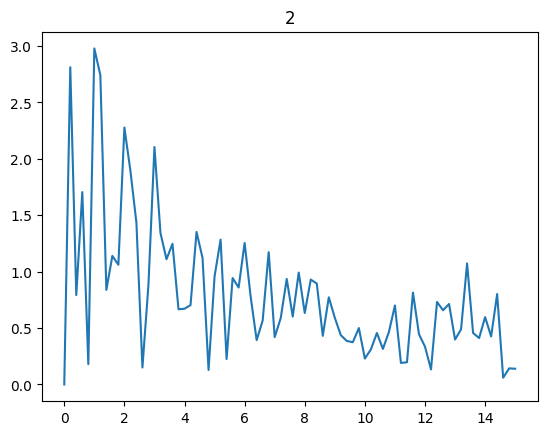

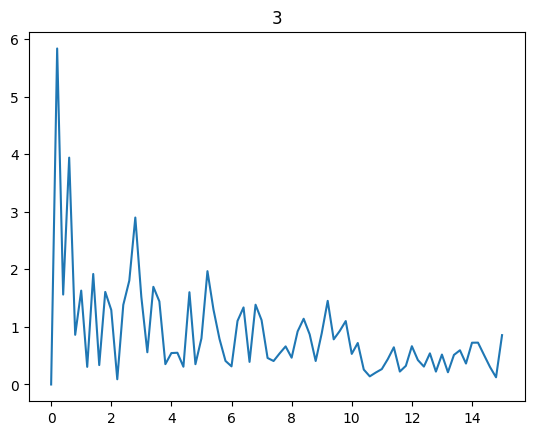

In [23]:
# Plotting the FFT of the three videos.
list_f = []
for i in range(1, 4):
    yf, xf = plot_fft(dict_frame_intensity[str(i)], sample_rate, 150, str(i))
    list_f.append(get_frequency(yf, xf))

In [45]:
# Printing out the frequency with max value
for index, f in enumerate(list_f):
    print("Frequency of heatbeat for {} : {} Hz".format(index+1, f))

Frequency of heatbeat for 1 : 0.39473684210526316 Hz
Frequency of heatbeat for 2 : 1.1842105263157894 Hz
Frequency of heatbeat for 3 : 0.39473684210526316 Hz


## Our understanding
We can see that the FFT for both the graphs for a 5 second sample is not that accurate.
To increase accuracy, we can look only at frequencies between the 1 (60bpm) - 3.67 (220bpm) - which is the usual heart beat frequency.

### Note : Looking only at the second and third graphs where there should be the most difference, we will then notice that the bpm for video 2 will be around 1.2Hz and that for video 3 will be between 2-3bpm. This would be as per expectation.

Another way to increase accuracy would be to increase the number of samples.

## End of Answer C

#### D. Likelihood Distributions [20 marks]
In the 5-second chunks taken above, choose 20 frames where your sensing metric is close to the local maximum (Case1), and 20 frames where it is close to the local minimum (Case2). Plot the histograms on "R", "G" and "B" values for each pixel in the 20 frames for the two cases 1 and 2. For each video there will be 3 figures, each for "R", "G" and "B". Which one produces the most separable distributions?

# Answer D

I am not very keen on manual work, so let us use some peak and trough detection algorithms to detect max points and min points. We can then manually verify if they are infact near local maximas and local minimas.

Using a max and min identifier can seem counter-intuitive, as we are figuring out a single threshold to just do that.
But the same argument can be made about choosing manually. 
All we want are cases near max and min points, so that we can plot distributions and check if our approach actually works. 
For that, we can either  choose for mins and maxs manually or use a pre-existing algorithm.
I prefer the latter.
(reference for algo - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)


In [25]:
# We use the scipy.signal.find_peaks which will classify peaks based on nearby values - it is a smart thresholding algorithm
dict_frame_intensity_peak_trough_points = {"1" : {}, "2" : {}, "3" : {}}
for index, frame_intensity in dict_frame_intensity.items():
    print("Number of frames check : ", len(frame_intensity))
    # Finds the max points
    peaks = list(scipy.signal.find_peaks(frame_intensity)[0])
    # Finds the min points We multiply to by -1 to get trough value as the function can only detect peaks
    troughs = list(scipy.signal.find_peaks(np.array(frame_intensity) * -1)[0])
    # Randomly choosing 20 frames from the max frames and min frames
    dict_frame_intensity_peak_trough_points[index]["Case_1"] = random.sample(peaks, 20)
    dict_frame_intensity_peak_trough_points[index]["Case_2"] = random.sample(troughs, 20)

# Checking if dict frame looks fine.
print("Checking if dict_frame_intensity_peak_trough is fine : ", dict_frame_intensity_peak_trough_points)

Number of frames check :  150
Number of frames check :  150
Number of frames check :  150
Checking if dict_frame_intensity_peak_trough is fine :  {'1': {'Case_1': [143, 69, 92, 12, 33, 27, 53, 43, 102, 62, 84, 126, 20, 16, 4, 131, 81, 134, 51, 145], 'Case_2': [24, 61, 137, 98, 48, 148, 78, 83, 70, 144, 100, 19, 55, 15, 117, 88, 6, 63, 119, 1]}, '2': {'Case_1': [49, 39, 80, 75, 52, 114, 116, 104, 57, 28, 109, 66, 100, 10, 138, 144, 98, 140, 90, 134], 'Case_2': [7, 101, 94, 81, 99, 130, 47, 35, 92, 45, 107, 142, 103, 11, 18, 88, 137, 37, 15, 146]}, '3': {'Case_1': [66, 42, 89, 121, 13, 60, 146, 124, 111, 131, 49, 76, 78, 102, 138, 38, 17, 142, 104, 134], 'Case_2': [97, 15, 103, 112, 132, 3, 29, 143, 127, 25, 53, 72, 91, 130, 74, 37, 114, 22, 137, 80]}}


In [26]:
# Creating a function that will create six plots - where evey column contains 3 plots correspoding to the three different colours B, G, R, and every main plot will 
# contains two plots for each hypothesis distribution
def plot_6(a1, a2, a3, b1, b2, b3, title_1, title_2, title_3):
    # bins = 255
    figure, axis = plt.subplots(3, 1)

    # Automatically calculating the number of bins which must be present in the histogram using min and max
    min_val = min(np.min(a1.flatten()), np.min(b1.flatten()), np.min(a2.flatten()), np.min(b2.flatten()), np.min(a3.flatten()), np.min(b3.flatten()))
    max_val = max(np.max(a1.flatten()), np.max(b1.flatten()), np.max(a2.flatten()), np.max(b2.flatten()), np.max(a3.flatten()), np.max(b3.flatten()))
    bins = int(max_val - min_val)

    # plotting the histograms
    axis[0].hist([a1.flatten(), b1.flatten()], bins, alpha=0.5, label=["Case 1 {}".format(title_1), "Case 2 {}".format(title_1)])
    axis[1].hist([a2.flatten(), b2.flatten()], bins, alpha=0.5, label=["Case 1 {}".format(title_2), "Case 2 {}".format(title_2)])
    axis[2].hist([a3.flatten(), b3.flatten()], bins, alpha=0.5, label=["Case 1 {}".format(title_3), "Case 2 {}".format(title_3)])
    
    plt.show()

In [27]:
# Defining a BGR list
bgr_list = ["B", "G", "R"]

##### Plotting histograms

Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000


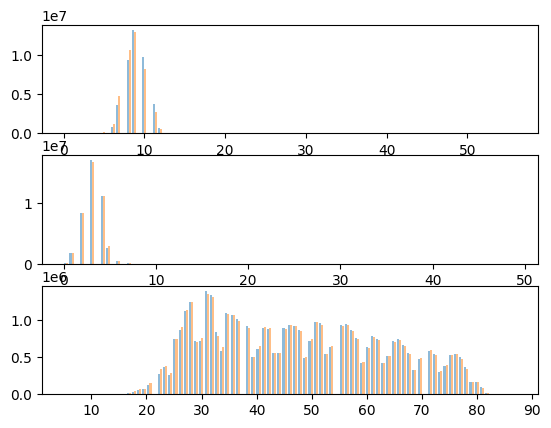

Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000


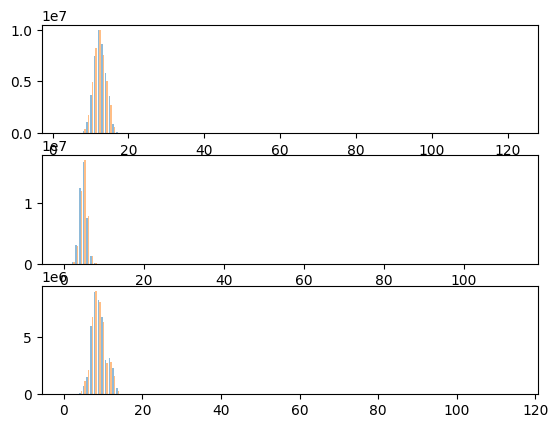

Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000
Len Check : 41472000


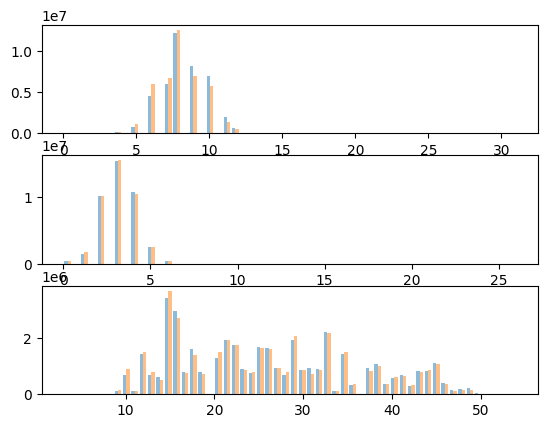

In [28]:
# This will contain a list of frames for each Case and for each video
dict_frame_intensity_peak_trough_frames = {"1" : {}, "2" : {}, "3" : {}}
# This will contain a list of pixel values for each B, G, R value across frames for each Case and for each video
dict_frame_intensity_peak_trough_frames_bgr_allpixels= {"1" : {}, "2" : {}, "3" : {}}

# Iterating through each video
for video_index, video in videoFrames_5s.items():
    # Finding the frames corresponding to max and min indexes
    case1_frames = [video[max_frame] for max_frame in dict_frame_intensity_peak_trough_points[video_index]["Case_1"]]
    case2_frames = [video[min_frame] for min_frame in dict_frame_intensity_peak_trough_points[video_index]["Case_2"]]
    
    
    case1_frames_bgr_all_pixels = {"B" : np.array([]), "G" : np.array([]), "R" : np.array([])}
    case2_frames_bgr_all_pixels = {"B" : np.array([]), "G" : np.array([]), "R" : np.array([])}
    # Iterating through each B, G, R value
    for bgr_index, bgr in enumerate(bgr_list):
        # For each frame of case 1, append all the values of the particular colour dimension
        for case1_frame in case1_frames:
            case1_frames_bgr_all_pixels[bgr] = np.append(case1_frames_bgr_all_pixels[bgr], case1_frame[:, :, bgr_index]).reshape(-1, 1)
        # For each frame of case 2, append all the values of the particular colour dimension
        for case2_frame in case2_frames:
            case2_frames_bgr_all_pixels[bgr] = np.append(case2_frames_bgr_all_pixels[bgr], case2_frame[:, :, bgr_index]).reshape(-1, 1)
    
    # Print check - number of pixels should be 20x1920x1080 = 41472000
    for bgr in bgr_list:
        print("Len Check : {}".format(len(case1_frames_bgr_all_pixels[bgr])))
        print("Len Check : {}".format(len(case2_frames_bgr_all_pixels[bgr])))

    # Plot the distributions
    plot_6(case1_frames_bgr_all_pixels["B"], case1_frames_bgr_all_pixels["G"], case1_frames_bgr_all_pixels["R"]
           , case2_frames_bgr_all_pixels["B"], case2_frames_bgr_all_pixels["G"], case2_frames_bgr_all_pixels["R"]
           , "B", "G", "R")

    # Save the data for future reference
    dict_frame_intensity_peak_trough_frames[video_index]["Case_1"] = case1_frames
    dict_frame_intensity_peak_trough_frames[video_index]["Case_2"] = case2_frames

    dict_frame_intensity_peak_trough_frames_bgr_allpixels[video_index]["Case_1"] = case1_frames_bgr_all_pixels
    dict_frame_intensity_peak_trough_frames_bgr_allpixels[video_index]["Case_2"] = case2_frames_bgr_all_pixels

## Analysis
##### Note that in the above graph, each plot has two distributions, one each for case 1 (red) and case 2 (blue).
We can see that the plots for both the hypothesis are close to the same. 
This implies that it will be very hard to find a threshold to separate them irresepective of which colour dimension we choose for our analysis.

That said, let us do a quick check if the plots makes sense by printing the mean of the data. 
If the means and stds are similar, it means that our plots are correct

In [29]:
for cases_bgr_index, cases_bgr in dict_frame_intensity_peak_trough_frames_bgr_allpixels.items():
    print("Sequence : {}".format(cases_bgr_index))
    case1_dict = cases_bgr["Case_1"]
    case2_dict = cases_bgr["Case_2"]
    for bgr_index in ["B", "G", "R"]:
        print("Case 1 - {} : {}\tMin : {}  Max : {}  Mean : {}  Std : {}"
              .format(bgr_index, case1_dict[bgr_index].shape, np.min(case1_dict[bgr_index]), np.max(case1_dict[bgr_index]), np.mean(case1_dict[bgr_index]), np.std(case1_dict[bgr_index])))
        print("Case 2 - {} : {}\tMin : {}  Max : {}  Mean : {}  Std : {}"
              .format(bgr_index, case2_dict[bgr_index].shape, np.min(case2_dict[bgr_index]), np.max(case2_dict[bgr_index]), np.mean(case2_dict[bgr_index]), np.std(case2_dict[bgr_index])))    

Sequence : 1
Case 1 - B : (41472000, 1)	Min : 0.0  Max : 53.0  Mean : 9.011560257523149  Std : 1.2587390570735766
Case 2 - B : (41472000, 1)	Min : 0.0  Max : 56.0  Mean : 8.778024136766975  Std : 1.2744660564590702
Case 1 - G : (41472000, 1)	Min : 0.0  Max : 49.0  Mean : 3.147850163966049  Std : 1.0307070414656847
Case 2 - G : (41472000, 1)	Min : 0.0  Max : 49.0  Mean : 3.1603356722608025  Std : 1.05038477213764
Case 1 - R : (41472000, 1)	Min : 5.0  Max : 86.0  Mean : 47.64054904513889  Std : 15.730831579394012
Case 2 - R : (41472000, 1)	Min : 6.0  Max : 87.0  Mean : 47.461939453125  Std : 15.758824675601465
Sequence : 2
Case 1 - B : (41472000, 1)	Min : 4.0  Max : 122.0  Mean : 12.36926885609568  Std : 1.649323942223934
Case 2 - B : (41472000, 1)	Min : 3.0  Max : 104.0  Mean : 12.081194347993828  Std : 1.6800082106369474
Case 1 - G : (41472000, 1)	Min : 0.0  Max : 113.0  Mean : 4.782529803240741  Std : 0.9768532415741673
Case 2 - G : (41472000, 1)	Min : 0.0  Max : 97.0  Mean : 4.818108

We can see that for each colour dimension in each sequence, the mean and std of the two cases are almost the same. 
This implies that they will have highly similar distributions which is also what our plots signify.

This tell us that we cannot have a single threshold to effectively split the data.
That said, let us continue with the questions and see where it leads us.

# End of answer D

#### E. Threshold Based Detection and ROC curve [25 marks]
Only consider the "R" channel for analysis. Suppose, we just use a single pixel (uniformly randomly chosen in the frame) to detect whether the frame belongs to case 1 or case 2. You can denote the "Case 1" to be the POSITIVE event/hypothesis and "Case 2" to be the NEGATIVE event/null hypothesis. For every threshold value, for every frame, choose 500 random pixels. Compute the "Probability of Detection" ($P_D$) and "Probability of False Alarm" ($P_{FA}$). Note that you have (20 + 20) = 40 frames, and 500 detections per frame, i.e., 20000 total detections. Plot the $ROC$ curve. Which one has the best ROC curve (Dataset 1, 2 or 3)?

#### F. Are "good" samples spatially correlated? [20 marks]
First, choose an optimal threshold, $T_{OPT}$, that best suits your data (maximize $P_D$ while minimizing $P_{FA}$, you may look into maximizing the $\frac{P_D}{P_{FA}}$ ratio). Out of the 20000 total detections above for $T_{OPT}$, can it be hypothesised that the "good" samples (true positives and true negatives) are spatially clustered in certain areas of the frame, compared to the "bad" samples (false positives and false negatives)?

# Answer to E and F - Solving two questions together
I do not quite understand question E.
<br>
Question E says, "For every threshold value, for every frame, choose 500 random pixels. Compute the "Probability of Detection" ($P_D$) and "Probability of False Alarm""
<br>
But this, to me, is confusing as the PD and PFA values are characterstic to the distributions as a whole.
<br>
And when it comes to dealing with individual samples and singular step thresholds, the output is not a probability but a mere 1 or 0, a "yes" or "no".

However looking at Questions E and F together, the only reasonable interpretation I can come up with is the below question
<br>
<br>
"How does the PFA and PD points (and thus the ROC curve) vary when we compare the distribution as a whole to that of a uniformly randomly sampled subspace?
Will the sub-distribution have a better ROC curve? (where better implies threshold points which will result in a high PD/PFA ratio?)
<br>
<br>
This to me looks like a valid question which ponders upon whether there are some pixels values which are adding noise to the image and producing hard to separate hypothesis distributions.
If we do answer this question, and the answer affirms, we can arrive at that conclusion that maybe we can remove focus on those pixels to increase SNR and improve our accuracy.

With this in mind, I look to solve both the questions together.
<br>
I will first plot the ROC curve for the entire dataset.
<br>
And then plot the ROC curve by create a sub-dataset (consisting of randomly chosen 500 points per frame as directed by question E)
<br>
<br>
Both the plots will be limited to the Red dimension.

## Now that we have that in place, let us plot the ROC for the entire data of 20+20 frames but limited to the Red Dimension

In [30]:
# This function will get the PD and PFA values
def get_prob_detection_fa(freq_distribution_h0, freq_distribution_h1, threshold_value):
    # Checks if threshold each there in each hypothesis distribution
    val_h0 = freq_distribution_h0.get(threshold_value, -1)
    val_h1 = freq_distribution_h1.get(threshold_value, -1)
    
    # If threshold is present
    if val_h0 != -1 and val_h1 != -1:
        # Tracks all the counts above threshold in hypothesis 0 distribution
        h0_count = 0
        # Tracks the total count of hypothesis 0 distribution
        h0_total_count = 0
        for thresh, count in freq_distribution_h0.items():
            if thresh >= threshold_value:
                h0_count += count
            h0_total_count += count

        # Tracks all the counts above threshold in hypothesis 1 distribution
        h1_count = 0
        # Tracks the total count of hypothesis 1 distribution
        h1_total_count = 0
        for thresh, count in freq_distribution_h1.items():
            if thresh >= threshold_value:
                h1_count += count
            h1_total_count += count

        # Returns the PFA and PD values 
        # where PFA = count above threshold/total count in h0 distribution
        # and where PD = count above threshold/total count in h1 distribution
        # We are basically finding the AREAS UNDER THE PROBABILITY CURVES in the discrete domain
        return ((h0_count/h0_total_count), (h1_count/h1_total_count))
    
    else : 
        return (-1, -1) 

In [31]:
# Gets the frequency distribution for H0 and H1 hypothesis
freq_distribution_red = {"1" : {}, "2" : {}, "3" : {}}
for video_index in ["1", "2", "3"]:
    # frequency distribution of h0
    unique, counts = np.unique(dict_frame_intensity_peak_trough_frames_bgr_allpixels[video_index]["Case_1"]["R"], return_counts=True)
    freq_distribution_red[video_index]["Case_1"] = dict(zip(unique, counts))
    # frequency distribution of h1
    unique, counts = np.unique(dict_frame_intensity_peak_trough_frames_bgr_allpixels[video_index]["Case_2"]["R"], return_counts=True)
    freq_distribution_red[video_index]["Case_2"] = dict(zip(unique, counts))

In [32]:
# A function which gets a set of threshold values to test on based on the min and max values of the h0 and h1 distributions
def get_threshold_value_range(freq_distribution, index):
    cases = freq_distribution[index]
    case1_keys = cases["Case_1"].keys()
    case2_keys = cases["Case_2"].keys()
    min_thresh = min(min(case1_keys), min(case2_keys))
    max_thresh = max(max(case1_keys), max(case2_keys))
    print(min_thresh, max_thresh)
    return min_thresh, max_thresh

In [33]:
# Getting the threshold values for each video
get_threshold_value_range(freq_distribution_red, "1")
get_threshold_value_range(freq_distribution_red, "2")
get_threshold_value_range(freq_distribution_red, "3")

5.0 87.0
0.0 115.0
3.0 54.0


(3.0, 54.0)

##### ROC Curve

5.0 87.0
0.0 115.0
3.0 54.0


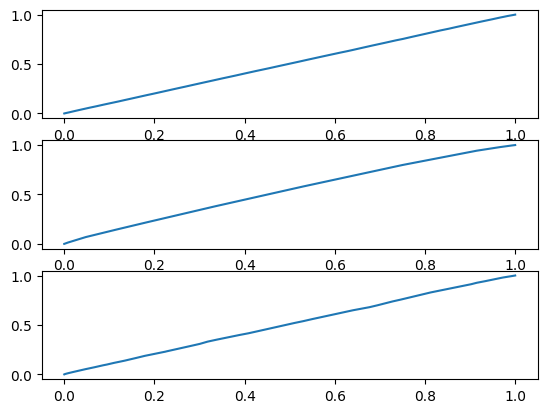

In [34]:
# For plotting ROC curve for each 
fix, ax = plt.subplots(3, 1)
# For each video
for index in ["1", "2", "3"]:
    pfa_list = []
    pd_list = []
    # Find list of threshold values
    min_thresh, max_thresh = get_threshold_value_range(freq_distribution_red, index)
    # For each threshold value
    for possible_thresh in range(int(min_thresh), int(max_thresh + 1)):
        # find PFA and PD
        pfa, pd = get_prob_detection_fa(freq_distribution_red[index]["Case_2"], freq_distribution_red[index]["Case_1"], possible_thresh)   
        if pfa == -1:
            continue  
        # Keep track of PFA and PD and plot
        pfa_list.append(pfa)
        pd_list.append(pd)
    ax[int(index) - 1].plot(pfa_list, pd_list)

# Plot the ROC Curve
plt.show()

## Intermediary analysis
The above is the graph for the ROC curve. It is quite linear indicating that PD/PFA value is constant.
What this implies is that the distributions are overlapping which is what we observed while plotting this histograms.

No suprises there.
<br>
<br>
Let us now look at a subset of 500 pixels from each of the 20+20 frames.
I hopethesize that since we take a random uniform sampling, there should be no change to the ROC Curve. 
Let us check it out.

In [35]:
# Creating a plotting function to plot a histogram where two distributions can be present - In our case the null hypothesis distribution
# and the h1 distribution
def plot_2(a1, b1, title_1 = ""):
    # Autocalculate bins
    min_val = min(np.min(a1.flatten()), np.min(b1.flatten()))
    max_val = max(np.max(a1.flatten()), np.max(b1.flatten()))
    bins = int(max_val - min_val)

    plt.hist([a1.flatten(), b1.flatten()], bins, alpha=0.5, label=["Case 1 {}".format(title_1), "Case 2 {}".format(title_1)])
    plt.show()

Len Check : 10000
Len Check : 10000


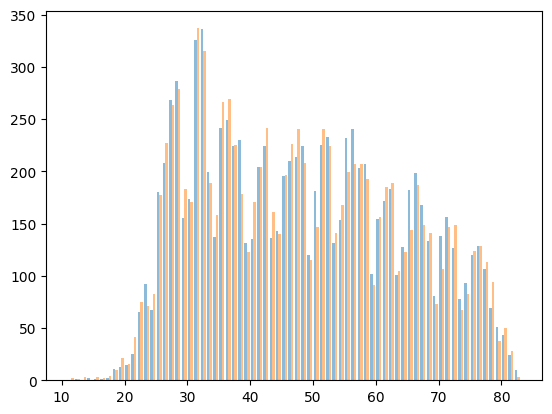

Len Check : 10000
Len Check : 10000


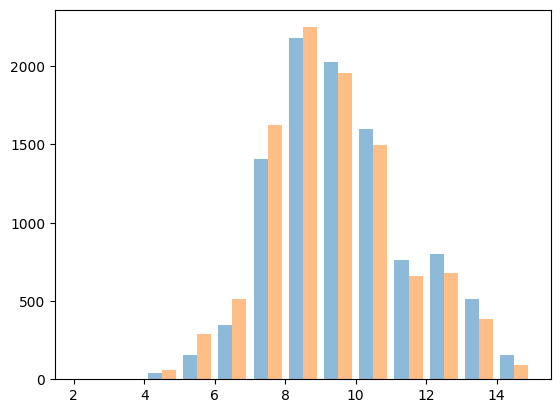

Len Check : 10000
Len Check : 10000


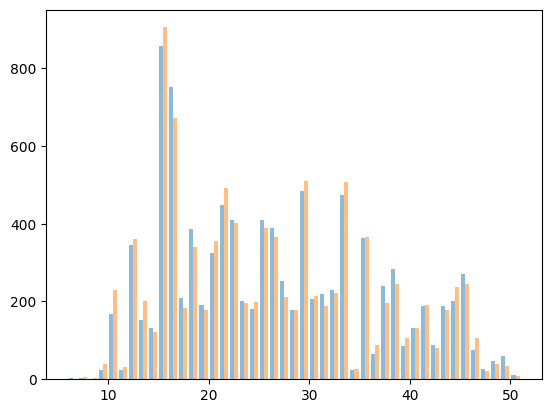

In [36]:
# Creating the distribution as per mentioned in Question E
# i.e For each of the 20+20 frames, choose 500 random pixels in the R dimension and plot the histograms

# I am NOT explaing this code line by line is at is an exact replica of the code use to plot histograms before.
# There is only one thing to note - np.random.choice randomly selects 500 points from the distribution

dict_frame_intensity_peak_trough_frames_r = {"1" : {}, "2" : {}, "3" : {}}
dict_frame_intensity_peak_trough_frames_r_20k = {"1" : {}, "2" : {}, "3" : {}}

for video_index, video in videoFrames_5s.items():
    case1_frames = [video[max_frame][:, :, 2] for max_frame in dict_frame_intensity_peak_trough_points[video_index]["Case_1"]]
    case2_frames = [video[min_frame][:, :, 2] for min_frame in dict_frame_intensity_peak_trough_points[video_index]["Case_2"]]
    case1_frames_r_20k = np.array([])
    case2_frames_r_20k = np.array([])
    
    
    for case1_frame in case1_frames:
        # Randomly choosing 500 pixels from each frame for Case 1
        case1_frames_r_20k = np.append(case1_frames_r_20k, np.random.choice(case1_frame.flatten(), 500, replace = False)).reshape(-1, 1)
    for case2_frame in case2_frames:
        # Randomly choosing 500 pixels from each frame for Case 2
        case2_frames_r_20k = np.append(case2_frames_r_20k, np.random.choice(case2_frame.flatten(), 500, replace = False)).reshape(-1, 1)
    
    # Print check - number of pixels should be 20x500 = 10000
    print("Len Check : {}".format(len(case1_frames_r_20k)))
    print("Len Check : {}".format(len(case2_frames_r_20k)))

    plot_2(case1_frames_r_20k, case2_frames_r_20k)

    dict_frame_intensity_peak_trough_frames_r[video_index]["Case_1"] = case1_frames
    dict_frame_intensity_peak_trough_frames_r[video_index]["Case_2"] = case2_frames

    dict_frame_intensity_peak_trough_frames_r_20k[video_index]["Case_1"] = case1_frames_r_20k
    dict_frame_intensity_peak_trough_frames_r_20k[video_index]["Case_2"] = case2_frames_r_20k

### The histograns are not distinguishable like we predicted.
### Let us still try to plot the ROC curve for the above

##### I am not explaing the below to code blocks line by line is at is an exact replica of the code use to plot ROC Curve before.

In [38]:
freq_distribution_red_20k = {"1" : {}, "2" : {}, "3" : {}}
for video_index in ["1", "2", "3"]:
    print(video_index)
    unique, counts = np.unique(dict_frame_intensity_peak_trough_frames_r_20k[video_index]["Case_1"], return_counts=True)
    freq_distribution_red_20k[video_index]["Case_1"] =  dict(zip(unique, counts))
    unique, counts = np.unique(dict_frame_intensity_peak_trough_frames_r_20k[video_index]["Case_2"], return_counts=True)
    freq_distribution_red_20k[video_index]["Case_2"] = dict(zip(unique, counts))

1
2
3


11.0 83.0
0
2.0 15.0
1
6.0 51.0
2


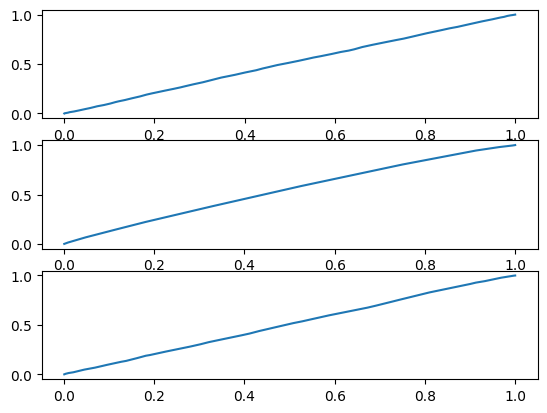

In [39]:
fix, ax = plt.subplots(3, 1)
for index in ["1", "2", "3"]:
    pfa_list = []
    pd_list = []
    min_thresh, max_thresh = get_threshold_value_range(freq_distribution_red_20k, index)
    for possible_thresh in range(int(min_thresh), int(max_thresh + 1)):
        pfa, pd = get_prob_detection_fa(freq_distribution_red_20k[index]["Case_2"], freq_distribution_red_20k[index]["Case_1"], possible_thresh)   
        if pfa == -1:
            continue  
        pfa_list.append(pfa)
        pd_list.append(pd)
    print(int(index) - 1)
    ax[int(index) - 1].plot(pfa_list, pd_list)
plt.show()

# Answer question E and F - Final analysis
Our hypothesis was right.

Randomly sampling to form a subset of data does not help us in any way.

The distribution is still not distinguishable and the ROC curve is still linear.
We thus cannot find a good singular threshold for such a plot as a good singular threshold is the one with max PD/PFA ratio and here the ratios are constants.

# A final attempt


I am not satisfied that we cannot differentiate between the distributions.
<br>
I want to make one final attempt.
<br>
A logical hypothesis that I have is that the center of the image should have the least amount of noise and thus the highest SNR.
<br>
This intuitively makes sense as that is the part which in the video seems to hold the least amount of black pixels and also the location
where some part of the finger of users will probably be always present.

<br>
<br>
Let us thus go on this endeavour one last time and see if we can make some progress

In [40]:
def crop_center(img, cropx=10, cropy=10):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

Len Check : 2000
Len Check : 2000


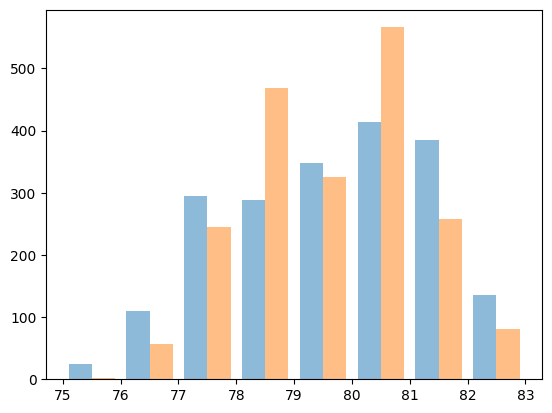

Len Check : 2000
Len Check : 2000


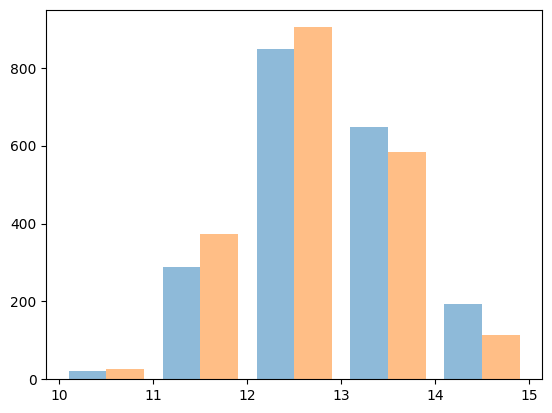

Len Check : 2000
Len Check : 2000


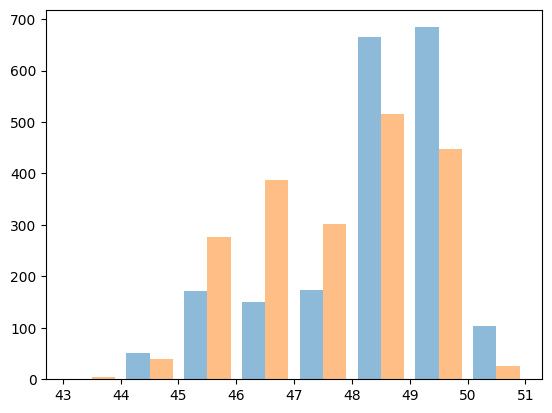

In [41]:
# I am NOT explaing this code line by line is at is an exact replica of the code use to plot ROC Curve before.
# There is only one thing to note - crop_center will crop the center 100 pixels from the frame

dict_frame_intensity_peak_trough_frames_r_center = {"1" : {}, "2" : {}, "3" : {}}
dict_frame_intensity_peak_trough_frames_r_center_100 = {"1" : {}, "2" : {}, "3" : {}}

for video_index, video in videoFrames_5s.items():
    case1_frames = [video[max_frame][:, :, 2] for max_frame in dict_frame_intensity_peak_trough_points[video_index]["Case_1"]]
    case2_frames = [video[min_frame][:, :, 2] for min_frame in dict_frame_intensity_peak_trough_points[video_index]["Case_2"]]
    case1_frames_r_center_100 = np.array([])
    case2_frames_r_center_100 = np.array([])
    
    
    for case1_frame in case1_frames:
        # Cropping the center pixels of image for Case 1
        case1_frames_r_center_100 = np.append(case1_frames_r_center_100, crop_center(case1_frame).flatten()).reshape(-1, 1)
    for case2_frame in case2_frames:
        # Cropping the center pixels of image for Case 2
        case2_frames_r_center_100 = np.append(case2_frames_r_center_100, crop_center(case2_frame).flatten()).reshape(-1, 1)
    
    # Print check - number of pixels should be 20x500 = 10000
    
    print("Len Check : {}".format(len(case1_frames_r_center_100)))
    print("Len Check : {}".format(len(case2_frames_r_center_100)))

    plot_2(case1_frames_r_center_100, case2_frames_r_center_100)

    dict_frame_intensity_peak_trough_frames_r_center[video_index]["Case_1"] = case1_frames
    dict_frame_intensity_peak_trough_frames_r_center[video_index]["Case_2"] = case2_frames

    dict_frame_intensity_peak_trough_frames_r_center_100[video_index]["Case_1"] = case1_frames_r_center_100
    dict_frame_intensity_peak_trough_frames_r_center_100[video_index]["Case_2"] = case2_frames_r_center_100

The distributions are looking a bit distinguishable.
<br>
Let us plot the ROC curve to check if this is indeed true or if it is just a combination of internal hope and a tired brain.

##### I am not explaing the below to code blocks line by line is at is an exact replica of the code use to plot ROC Curve before.

In [42]:
freq_distribution_r_center_100 = {"1" : {}, "2" : {}, "3" : {}}
for video_index in ["1", "2", "3"]:
    print(video_index)
    unique, counts = np.unique(dict_frame_intensity_peak_trough_frames_r_center_100[video_index]["Case_1"], return_counts=True)
    freq_distribution_r_center_100[video_index]["Case_1"] =  dict(zip(unique, counts))
    unique, counts = np.unique(dict_frame_intensity_peak_trough_frames_r_center_100[video_index]["Case_2"], return_counts=True)
    freq_distribution_r_center_100[video_index]["Case_2"] = dict(zip(unique, counts))

1
2
3


75.0 83.0
10.0 15.0
43.0 51.0


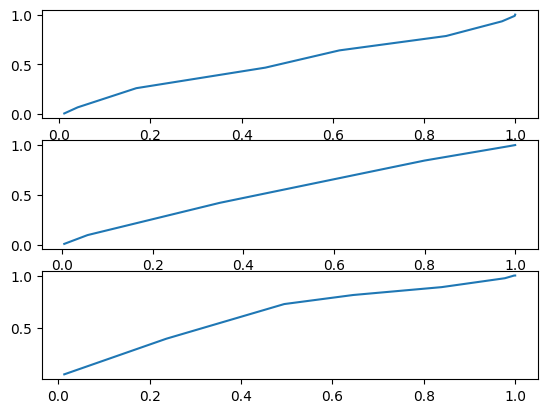

In [43]:
fix, ax = plt.subplots(3, 1)
for index in ["1", "2", "3"]:
    pfa_list = []
    pd_list = []
    min_thresh, max_thresh = get_threshold_value_range(freq_distribution_r_center_100, index)
    for possible_thresh in range(int(min_thresh), int(max_thresh + 1)):
        pfa, pd = get_prob_detection_fa(freq_distribution_r_center_100[index]["Case_2"], freq_distribution_r_center_100[index]["Case_1"], possible_thresh)   
        if pfa == -1:
            continue  
        pfa_list.append(pfa)
        pd_list.append(pd)
    ax[int(index) - 1].plot(pfa_list, pd_list)
plt.show()

# Final result - some hope
We can clearly see that the ROC curve is less linear when compared to all other previous cases. This is especially true for Recording 3.
For Recording 3, a reasonable threshold value "gamma", will thus be around 0.75/0.6.

This shows us that some experimentation around could help us deliver better singular threshold values.
That said, I would still prefer a more dynamic thresholding to classify heartbeats.
<br>
<br>

# Possible next steps

1. Sample at a higher frame rate
2. Check this for a longer sampling duration
<br>
<br>
But let us leave that for the future. 
For now, Adios. 

#### Submission (report document: 10 marks)
##### Deadline: $4^{th}$, March, 2023
* Compress the top level directory (ZIP format) containing this notebook with filled-in code along with the ppgvideos folder.
* Include a PDF file (10 marks) within the directory, name it "report.pdf". Mention your name and roll number.
* The report should contain explanations related to the above assignments (A through F), assumptions if any, specific code explanations, algorithms used and inferences made from the plots. Also include references if any.
* <b>You MUST not consult your homework code with others</b>. Any plagiarism found in your code (or somebody who is referring to your code) will result in zero credits in this assignment.
* Submissions after the deadline will not be entertained.